In [1]:
# Jupyter magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

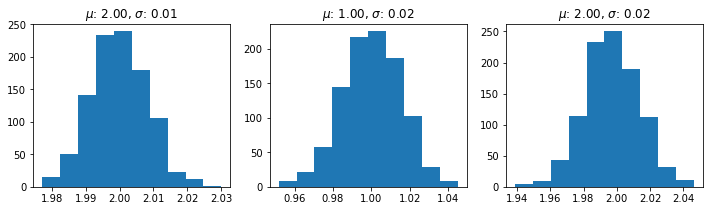

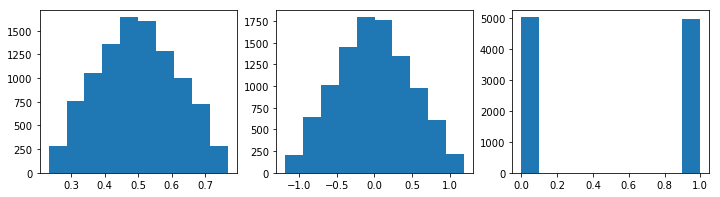

In [91]:
import numpy as np
from sklearn.linear_model import Lasso, MultiTaskLasso, MultiTaskLassoCV, LinearRegression
import matplotlib.pyplot as plt
from linear_te import gen_data, dml_fit, dml_crossfit
from scipy.special import expit

def main():
    n_samples = 10000 # samples used for estimation
    dim_x = 1 # dimension of controls x
    dim_z = 1 # dimension of variables used for heterogeneity (subset of x)
    kappa_z = 1 # support size of control function
    kappa_theta = 1 # support size of target parameter
    sigma_epsilon = 1 # variance of error in primary moment equation
    sigma_eta = .2 # variance of error in primary moment equation
    sigma_x = 3
    lambda_coef = 1 # coeficient in front of the asymptotic rate for regularization lambda

    l2_direct = []
    l2_ortho = []
    l2_cross_ortho = []
    l1_direct = []
    l1_ortho = []
    l1_cross_ortho = []
    direct_theta = []
    omit_z = []
    weighted = []
    for _ in range(1000):
        # Generate data
        x = np.random.uniform(-sigma_x, sigma_x, size=(n_samples, dim_x))
        z = np.random.uniform(-sigma_x, sigma_x, size=(n_samples, dim_z))
        theta = np.random.uniform(2, 2, size=(kappa_theta, 1))
        alpha_z = np.random.uniform(1, 1, size=(kappa_z, 1))
        beta_z = np.random.uniform(1, 1, size=(kappa_theta, 1))
        gamma_z = np.random.uniform(1, 1, size=(kappa_z, 1))
        y = np.dot(x, theta) + np.dot(z, alpha_z) + np.random.normal(0, sigma_epsilon, size=(n_samples, 1))
        y = y.ravel()
        index_d = sigma_eta * (np.dot(x, beta_z) + np.dot(z, gamma_z))
        p_d = expit(index_d).ravel()
        d = np.random.binomial(1, p_d)
        dy = d*y
        
        
        comp_x = np.concatenate((x, z), axis=1)
        model_y = LinearRegression(fit_intercept=True)
        model_y.fit(comp_x[d==1], dy[d==1])
        direct_theta.append(model_y.coef_[0])
        
        model_final = LinearRegression(fit_intercept=True)
        model_final.fit(x, dy)
        omit_z.append(model_final.coef_[0])
        
        model_final.fit(x, dy, sample_weight=d / p_d)
        model_lasso = LinearRegression(fit_intercept=True)
        sample_weight=d / p_d
        model_lasso.fit(np.sqrt(sample_weight.reshape(-1, 1)) * x, np.sqrt(sample_weight) * dy)
        weighted.append(model_lasso.coef_[0])
        
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.hist(np.array(direct_theta))
    plt.title("$\mu$: {:.2f}, $\sigma$: {:.2f}".format(np.mean(direct_theta), np.std(direct_theta)))
    plt.subplot(1, 3, 2)
    plt.hist(np.array(omit_z))
    plt.title("$\mu$: {:.2f}, $\sigma$: {:.2f}".format(np.mean(omit_z), np.std(omit_z)))
    plt.subplot(1, 3, 3)
    plt.hist(np.array(weighted))
    plt.title("$\mu$: {:.2f}, $\sigma$: {:.2f}".format(np.mean(weighted), np.std(weighted)))
    plt.show()
    
    plt.figure(figsize=(12,3))
    plt.subplot(1, 3, 1)
    plt.hist(p_d)
    plt.subplot(1, 3, 2)
    plt.hist(index_d)
    plt.subplot(1, 3, 3)
    plt.hist(d)
    plt.show()

    return
    
main()